# 3.1) 국내 프로야구 연봉 예측 [타자연봉예측]



# <Step1. 탐색> 프로야구 연봉 데이터 살펴보기

### [프로야구 연봉 데이터셋의 기본 정보]

In [118]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

In [119]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20180306-3).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/n

In [120]:
plt.rc('font', family='NanumBarunGothic') 

In [121]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [122]:
picher_file_path = '/content/gdrive/MyDrive/데이터시각화01/data/data/picher_stats_2017.csv'
batter_file_path = '/content/gdrive/MyDrive/데이터시각화01/data/data/batter_stats_2017.csv'
picher = pd.read_csv(picher_file_path)
batter = pd.read_csv(batter_file_path)

In [123]:
batter.columns

Index(['선수명', '팀명', '경기', '타석', '타수', '안타', '홈런', '득점', '타점', '볼넷', '삼진', '도루',
       'BABIP', '타율', '출루율', '장타율', 'OPS', 'wOBA', 'WAR', '연봉(2018)',
       '연봉(2017)'],
      dtype='object')

In [124]:
batter.head()

,선수명,팀명,경기,타석,타수,안타,홈런,득점,타점,볼넷,...,도루,BABIP,타율,출루율,장타율,OPS,wOBA,WAR,연봉(2018),연봉(2017)
0,최정,SK,130,527,430,136,46,89,113,70,...,1,0.316,0.316,0.427,0.684,1.111,0.442,7.30,120000,120000
1,최형우,KIA,142,629,514,176,26,98,120,96,...,0,0.362,0.342,0.450,0.576,1.026,0.430,7.20,150000,150000
2,박건우,두산,131,543,483,177,20,91,78,41,...,20,0.39,0.366,0.424,0.582,1.006,0.424,7.04,37000,19500
3,나성범,NC,125,561,498,173,24,103,99,48,...,17,0.413,0.347,0.415,0.584,0.999,0.416,5.64,43000,35000
4,손아섭,롯데,144,667,576,193,20,113,80,83,...,25,0.374,0.335,0.420,0.514,0.934,0.398,5.60,150000,65000


In [125]:
print(batter.shape)

(191, 21)


###### 예측할 대상인 '연봉'에 대한 정보

In [126]:
batter['연봉(2018)'].describe()

count       191.000000
mean      20625.654450
std       31978.855209
min        2700.000000
25%        4200.000000
50%        7500.000000
75%       25000.000000
max      250000.000000
Name: 연봉(2018), dtype: float64

<Axes: >

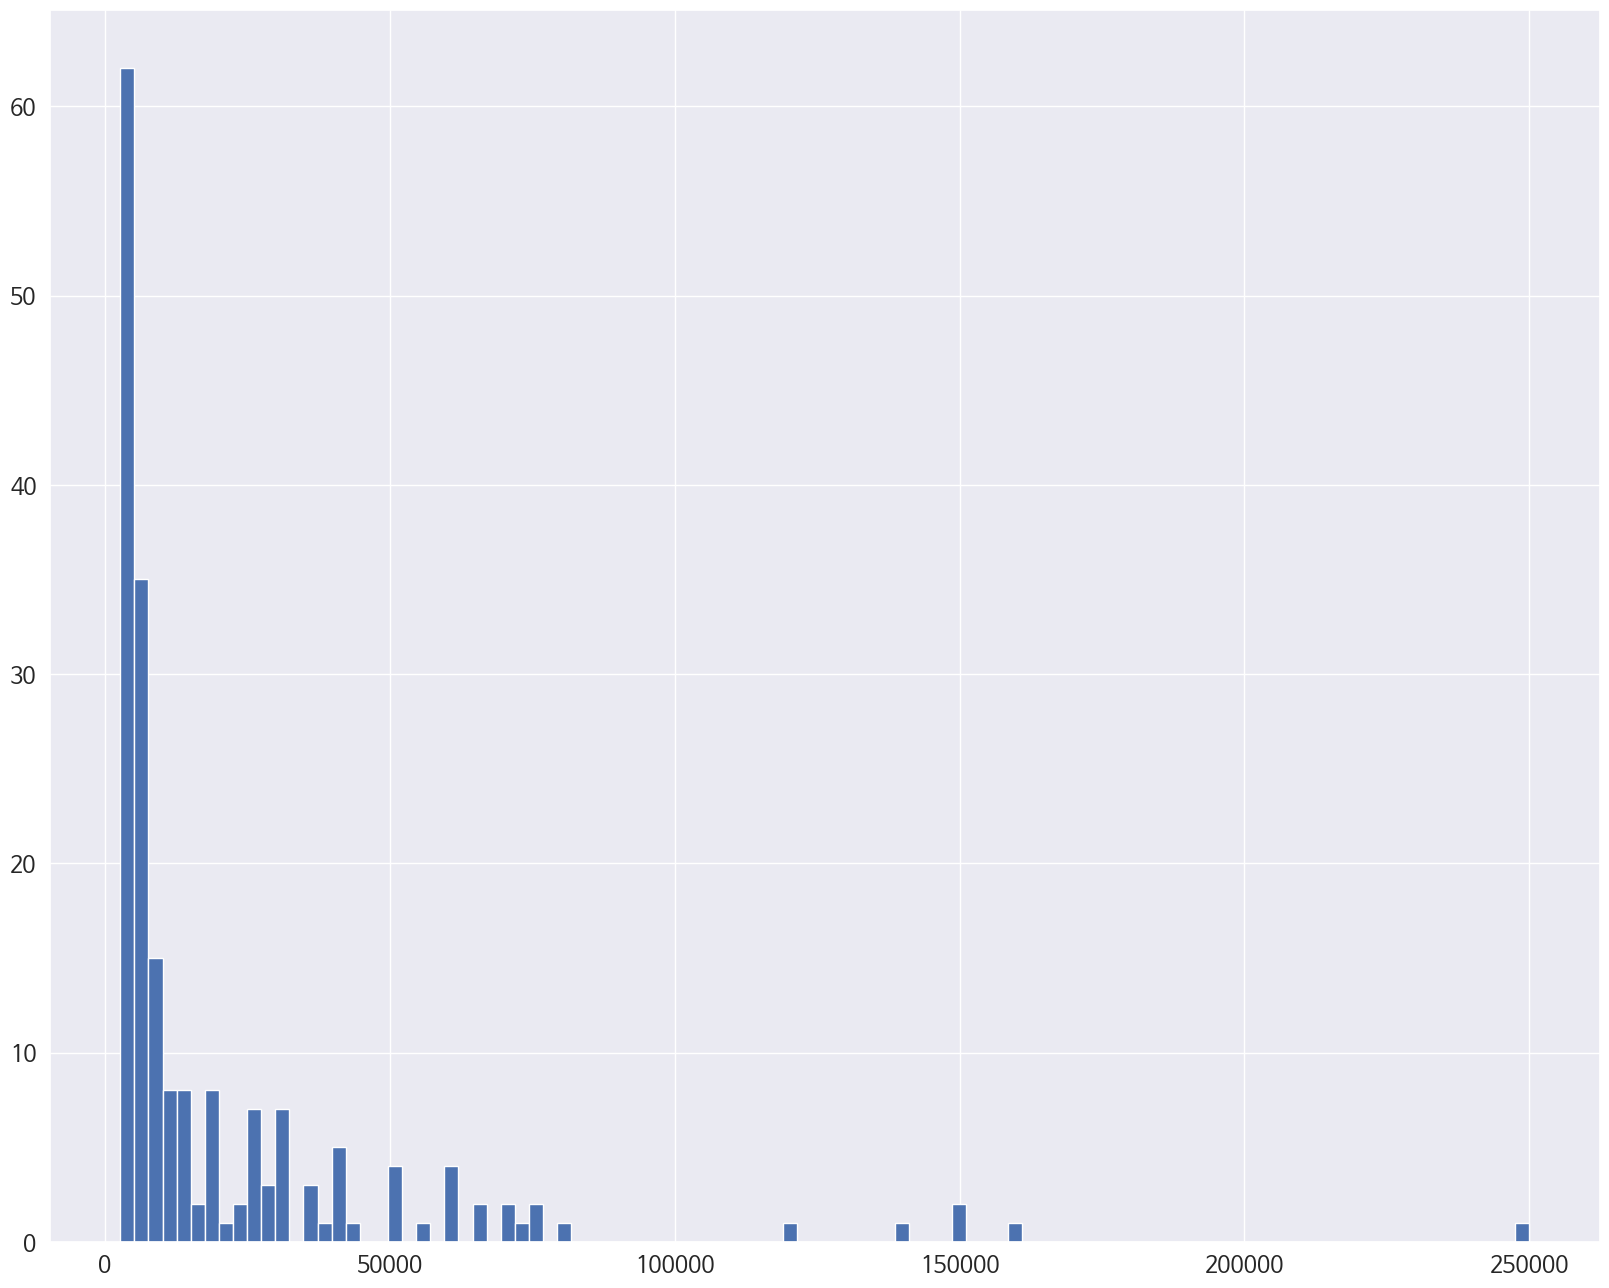

In [127]:
batter['연봉(2018)'].hist(bins=100) 
# 2018년 연봉 분포를 출력합니다.

<Axes: >

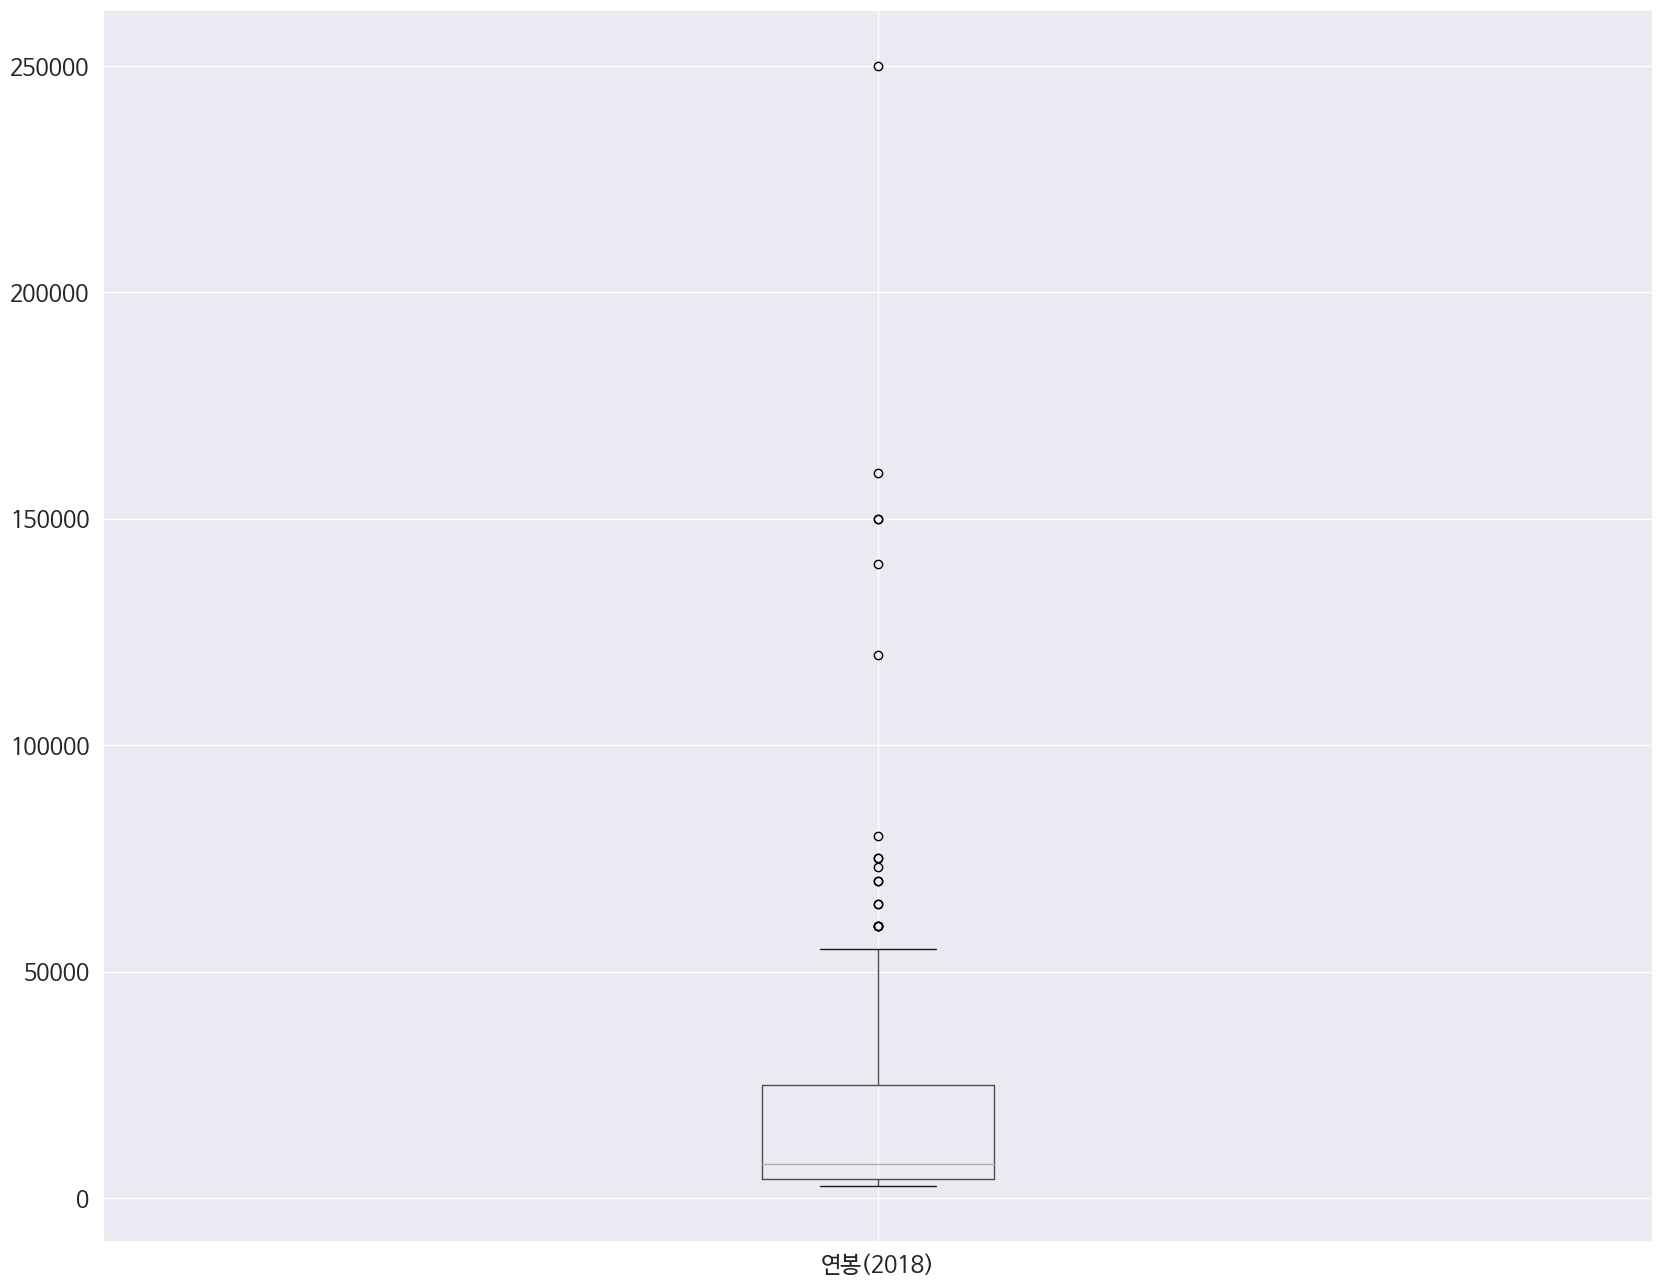

In [128]:
batter.boxplot(column=['연봉(2018)']) 
# 연봉의 Boxplot을 출력합니다.

-----

### [회귀 분석에 사용할 Batter(타자) 살펴보기]

In [129]:
batter_features_df = batter[['경기', '타석', '타수', '안타', '홈런', '득점', '타점', '볼넷', '삼진', '도루',
       'BABIP', '타율', '출루율', '장타율', 'OPS', 'wOBA', 'WAR', '연봉(2018)',
       '연봉(2017)']]

In [130]:
# Batter(타자) 각각에 대한 histogram을 출력합니다.
def plot_hist_each_column(df):
    plt.rcParams['figure.figsize'] = [20, 16]
    fig = plt.figure(1)
    
    # df의 column 갯수 만큼의 subplot을 출력합니다.
    for i in range(len(df.columns)):
        ax = fig.add_subplot(5, 5, i+1)
        plt.hist(df[df.columns[i]], bins=50)
        ax.set_title(df.columns[i])
    plt.show()

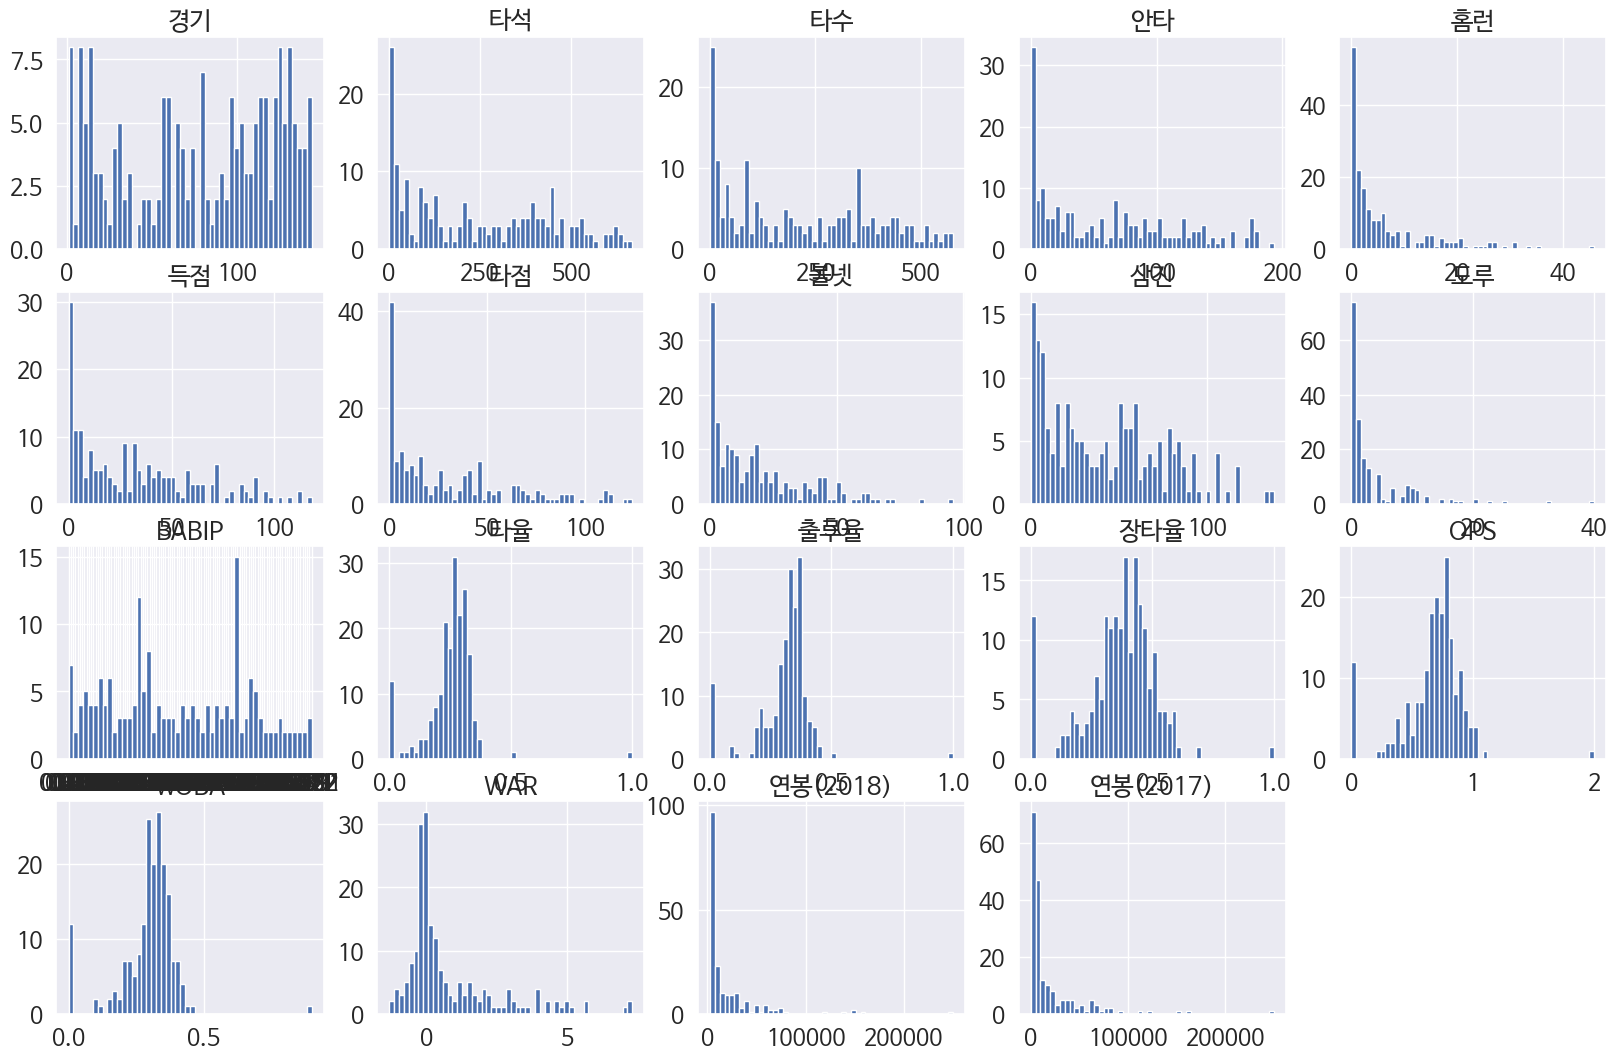

In [131]:
plot_hist_each_column(batter_features_df)

-----

### [Batter(타자)들의 단위 맞춰주기 : Batter(타자) 스케일링]

In [132]:
# pandas 형태로 정의된 데이터를 출력할 때, scientific-notation이 아닌 float 모양으로 출력되게 해줍니다.
pd.options.mode.chained_assignment = None

In [133]:
# Batter(타자) 각각에 대한 scaling을 수행하는 함수를 정의합니다.
def standard_scaling(df, scale_columns):
    for col in scale_columns:
        series_mean = df[col].mean()
        series_std = df[col].std()
        df[col] = df[col].apply(lambda x: (x-series_mean)/series_std)
    return df

In [134]:
# Batter(타자) 각각에 대한 scaling을 수행합니다.
scale_columns = ['경기', '타석', '타수', '안타', '홈런', '득점', '타점', '볼넷', '삼진', '도루',
       'BABIP', '타율', '출루율', '장타율', 'OPS', 'wOBA', 'WAR', '연봉(2017)']

# BABIP 변수가 string으로 되어 있어 실수로 변환해야 합니다. 실수로 변환하는 예제 코드 입니다. 
batter['BABIP'] = pd.to_numeric(batter['BABIP'], errors='coerce')

# NaN 값을 가지는 행 삭제
batter.dropna(inplace=True)

# "BABIP" 열의 모든 값을 float으로 변환
batter['BABIP'] = batter['BABIP'].astype(float)

batter_df = standard_scaling(batter, scale_columns)

In [135]:
batter_df = batter_df.rename(columns={'연봉(2018)': 'y'})
batter_df.head(5)

,선수명,팀명,경기,타석,타수,안타,홈런,득점,타점,볼넷,...,도루,BABIP,타율,출루율,장타율,OPS,wOBA,WAR,y,연봉(2017)
0,최정,SK,1.146280,1.429899,1.226996,1.340002,4.612026,1.867316,2.596359,2.590002,...,-0.450547,0.101238,0.642835,1.068564,2.172963,1.747163,1.389986,3.847066,120000,3.255177
1,최형우,KIA,1.411397,1.948878,1.712815,2.070092,2.283339,2.169865,2.817943,3.921803,...,-0.618069,0.460774,0.898643,1.275414,1.431059,1.405871,1.276412,3.787944,150000,4.223959
2,박건우,두산,1.168374,1.511307,1.533525,2.088344,1.584733,1.934549,1.488442,1.104532,...,2.732376,0.679622,1.134774,1.041584,1.472276,1.325567,1.219625,3.693348,37000,0.009756
3,나성범,NC,1.035815,1.602892,1.620278,2.015335,2.050470,2.337948,2.153192,1.463094,...,2.229809,0.859390,0.947837,0.960643,1.486014,1.297460,1.143909,2.865634,43000,0.510293
4,손아섭,롯데,1.455583,2.142224,2.071395,2.380380,1.584733,2.674115,1.551751,3.255903,...,3.569987,0.554566,0.829772,1.005610,1.005150,1.036472,0.973548,2.841985,150000,1.479076


-----

### [Batter(타자)들의 단위 맞춰주기 : one-hot-encoding]

In [136]:
# 팀명 Batter(타자)를 one-hot encoding으로 변환합니다.
team_encoding = pd.get_dummies(batter_df['팀명'])
batter_df = batter_df.drop('팀명', axis=1)
batter_df = batter_df.join(team_encoding)

In [137]:
team_encoding.head(5)

,KIA,KT,LG,NC,SK,넥센,두산,롯데,삼성,한화
0,0,0,0,0,1,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0
3,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0


In [138]:
batter_df.head()

,선수명,경기,타석,타수,안타,홈런,득점,타점,볼넷,삼진,...,KIA,KT,LG,NC,SK,넥센,두산,롯데,삼성,한화
0,최정,1.146280,1.429899,1.226996,1.340002,4.612026,1.867316,2.596359,2.590002,1.956427,...,0,0,0,0,1,0,0,0,0,0
1,최형우,1.411397,1.948878,1.712815,2.070092,2.283339,2.169865,2.817943,3.921803,1.199727,...,1,0,0,0,0,0,0,0,0,0
2,박건우,1.168374,1.511307,1.533525,2.088344,1.584733,1.934549,1.488442,1.104532,0.654904,...,0,0,0,0,0,0,1,0,0,0
3,나성범,1.035815,1.602892,1.620278,2.015335,2.050470,2.337948,2.153192,1.463094,2.228839,...,0,0,0,1,0,0,0,0,0,0
4,손아섭,1.455583,2.142224,2.071395,2.380380,1.584733,2.674115,1.551751,3.255903,1.623479,...,0,0,0,0,0,0,0,1,0,0


-----

### [회귀 분석 적용하기]

##### 회귀 분석을 위한 학습, 테스트 데이터셋 분리

In [139]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

In [140]:
# 학습 데이터와 테스트 데이터로 분리합니다.
X = batter_df[batter_df.columns.difference(['선수명', 'y'])]
y = batter_df['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=19)

##### 회귀 분석 계수 학습 & 학습된 계수 출력

In [141]:
# 회귀 분석 계수를 학습합니다 (회귀 모델 학습)
lr = linear_model.LinearRegression()
model = lr.fit(X_train, y_train)

In [142]:
# 학습된 계수를 출력합니다.
print(lr.coef_)

[  -286.66725331   -596.6563164   -2508.8909082    -145.35400304
  -3659.69385711 -23881.50990641   -932.17059261   2243.67349899
  66020.45451559   1349.31181177  -1962.54270653   1163.68410693
   1443.39567787  -1911.30302807   8066.67441764  11172.60558353
   -289.11992369  -1237.71060871   8358.85741822  27264.38516934
 -11549.59972622 -38370.39490825 -54539.5082726   40963.24066228
   5502.43570068  -1843.70772539    584.35821207   4066.75714808]


In [143]:
batter_df.columns

Index(['선수명', '경기', '타석', '타수', '안타', '홈런', '득점', '타점', '볼넷', '삼진', '도루',
       'BABIP', '타율', '출루율', '장타율', 'OPS', 'wOBA', 'WAR', 'y', '연봉(2017)',
       'KIA', 'KT', 'LG', 'NC', 'SK', '넥센', '두산', '롯데', '삼성', '한화'],
      dtype='object')

-----

# <Step3. 평가> : 예측 모델 평가하기

### [어떤 Batter(타자)가 가장 영향력이 강한 Batter(타자)일까]

In [144]:
!pip install statsmodels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [145]:
import statsmodels.api as sm

# statsmodel 라이브러리로 회귀 분석을 수행합니다.
X_train = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.931
Model:                            OLS   Adj. R-squared:                  0.916
Method:                 Least Squares   F-statistic:                     64.46
Date:                Tue, 09 May 2023   Prob (F-statistic):           3.98e-60
Time:                        14:12:00   Log-Likelihood:                -1567.6
No. Observations:                 152   AIC:                             3189.
Df Residuals:                     125   BIC:                             3271.
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.919e+04    603.680     31.794      0.000     1.8e+04    2.04e+04
BABIP       -286.6673   1460.245     -0.196      0.845   -3176.673    2603.338
KIA         1322.6645   2018.830      0.655      0.514   -2672.851    5318.180
KT          -589.5701   2193.478     -0.269      0.789   -4930.735    3751.595
LG          1773.9668   2054.895      0.863      0.390   -2292.926    5840.859
NC         -1740.3731   2089.529     -0.833      0.406   -5875.810    2395.063
OPS        -2.388e+04   1.32e+04     -1.808      0.073      -5e+04    2257.991
SK           987.1502   2195.699      0.450      0.654   -3358.411    5332.711
WAR         2243.6735   3114.993      0.720      0.473   -3921.283    8408.630
wOBA        6.602e+04    3.8e+04      1.738      0.085   -9173.519    1.41e+05
경기          1349.3118   2704.580      0.499      0.619   -4003.387    6702.011
넥센           -43.2219   1957.165     -0.022      0.982   -3916.694    3830.250
도루          1163.6841   1086.666      1.071      0.286    -986.963    3314.331
두산          3362.7165   2291.796      1.467      0.145   -1173.033    7898.466
득점         -1911.3030   3365.332     -0.568      0.571   -8571.713    4749.107
롯데          9985.9952   2269.232      4.401      0.000    5494.904    1.45e+04
볼넷          1.117e+04   3599.987      3.104      0.002    4047.784    1.83e+04
삼성          1630.2009   2014.575      0.809      0.420   -2356.893    5617.294
삼진         -1237.7106   2128.249     -0.582      0.562   -5449.779    2974.358
안타          8358.8574   1.06e+04      0.785      0.434   -1.27e+04    2.94e+04
연봉(2017)    2.726e+04   1253.237     21.755      0.000    2.48e+04    2.97e+04
장타율        -1.155e+04   7355.004     -1.570      0.119   -2.61e+04    3006.866
출루율        -3.837e+04   2.05e+04     -1.876      0.063   -7.88e+04    2106.553
타석         -5.454e+04   3.74e+04     -1.459      0.147   -1.29e+05    1.94e+04
타수          4.096e+04   3.88e+04      1.055      0.293   -3.59e+04    1.18e+05
타율          5502.4357   4056.607      1.356      0.177   -2526.093    1.35e+04
타점         -1843.7077   3900.117     -0.473      0.637   -9562.522    5875.107
한화          2503.6790   2044.190      1.225      0.223   -1542.026    6549.384
홈런          4066.7571   2981.359      1.364      0.175   -1833.722    9967.236
==============================================================================
Omnibus:                      107.444   Durbin-Watson:                   2.179
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2614.817
Skew:                           2.022   Prob(JB):                         0.00
Kurtosis:                      22.913   Cond. No.                     4.44e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is co

In [146]:
# 회귀 계수를 리스트로 반환합니다.
coefs = model.params.tolist()
coefs_series = pd.Series(coefs)
print(coefs_series)

0     19193.207782
1      -286.667253
2      1322.664462
3      -589.570130
4      1773.966775
5     -1740.373079
6    -23881.509906
7       987.150186
8      2243.673499
9     66020.454516
10     1349.311812
11      -43.221928
12     1163.684107
13     3362.716456
14    -1911.303028
15     9985.995196
16    11172.605584
17     1630.200855
18    -1237.710609
19     8358.857418
20    27264.385169
21   -11549.599726
22   -38370.394908
23   -54539.508273
24    40963.240662
25     5502.435701
26    -1843.707725
27     2503.678990
28     4066.757148
dtype: float64


-----

### [예측 모델의 평가]

In [147]:
# 학습 데이터와 테스트 데이터로 분리합니다.
X = batter_df[batter_df.columns.difference(['선수명', 'y'])]
y = batter_df['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=19)

In [148]:
# 회귀 분석 모델을 학습합니다.
lr = linear_model.LinearRegression()
model = lr.fit(X_train, y_train)

##### R2 score

In [149]:
# 회귀 분석 모델을 평가합니다.
print(model.score(X_train, y_train)) # train R2 score를 출력합니다.
print(model.score(X_test, y_test)) # test R2 score를 출력합니다.

0.930589754693465
0.9560774772743539


##### RMSE score

In [150]:
# 회귀 분석 모델을 평가합니다.
y_predictions = lr.predict(X_train)
print(sqrt(mean_squared_error(y_train, y_predictions))) # train RMSE score를 출력합니다.
y_predictions = lr.predict(X_test)
print(sqrt(mean_squared_error(y_test, y_predictions))) # test RMSE score를 출력합니다.

7290.954007827844
9462.93080013051


### [Batter(타자)들의 상관관계 분석]

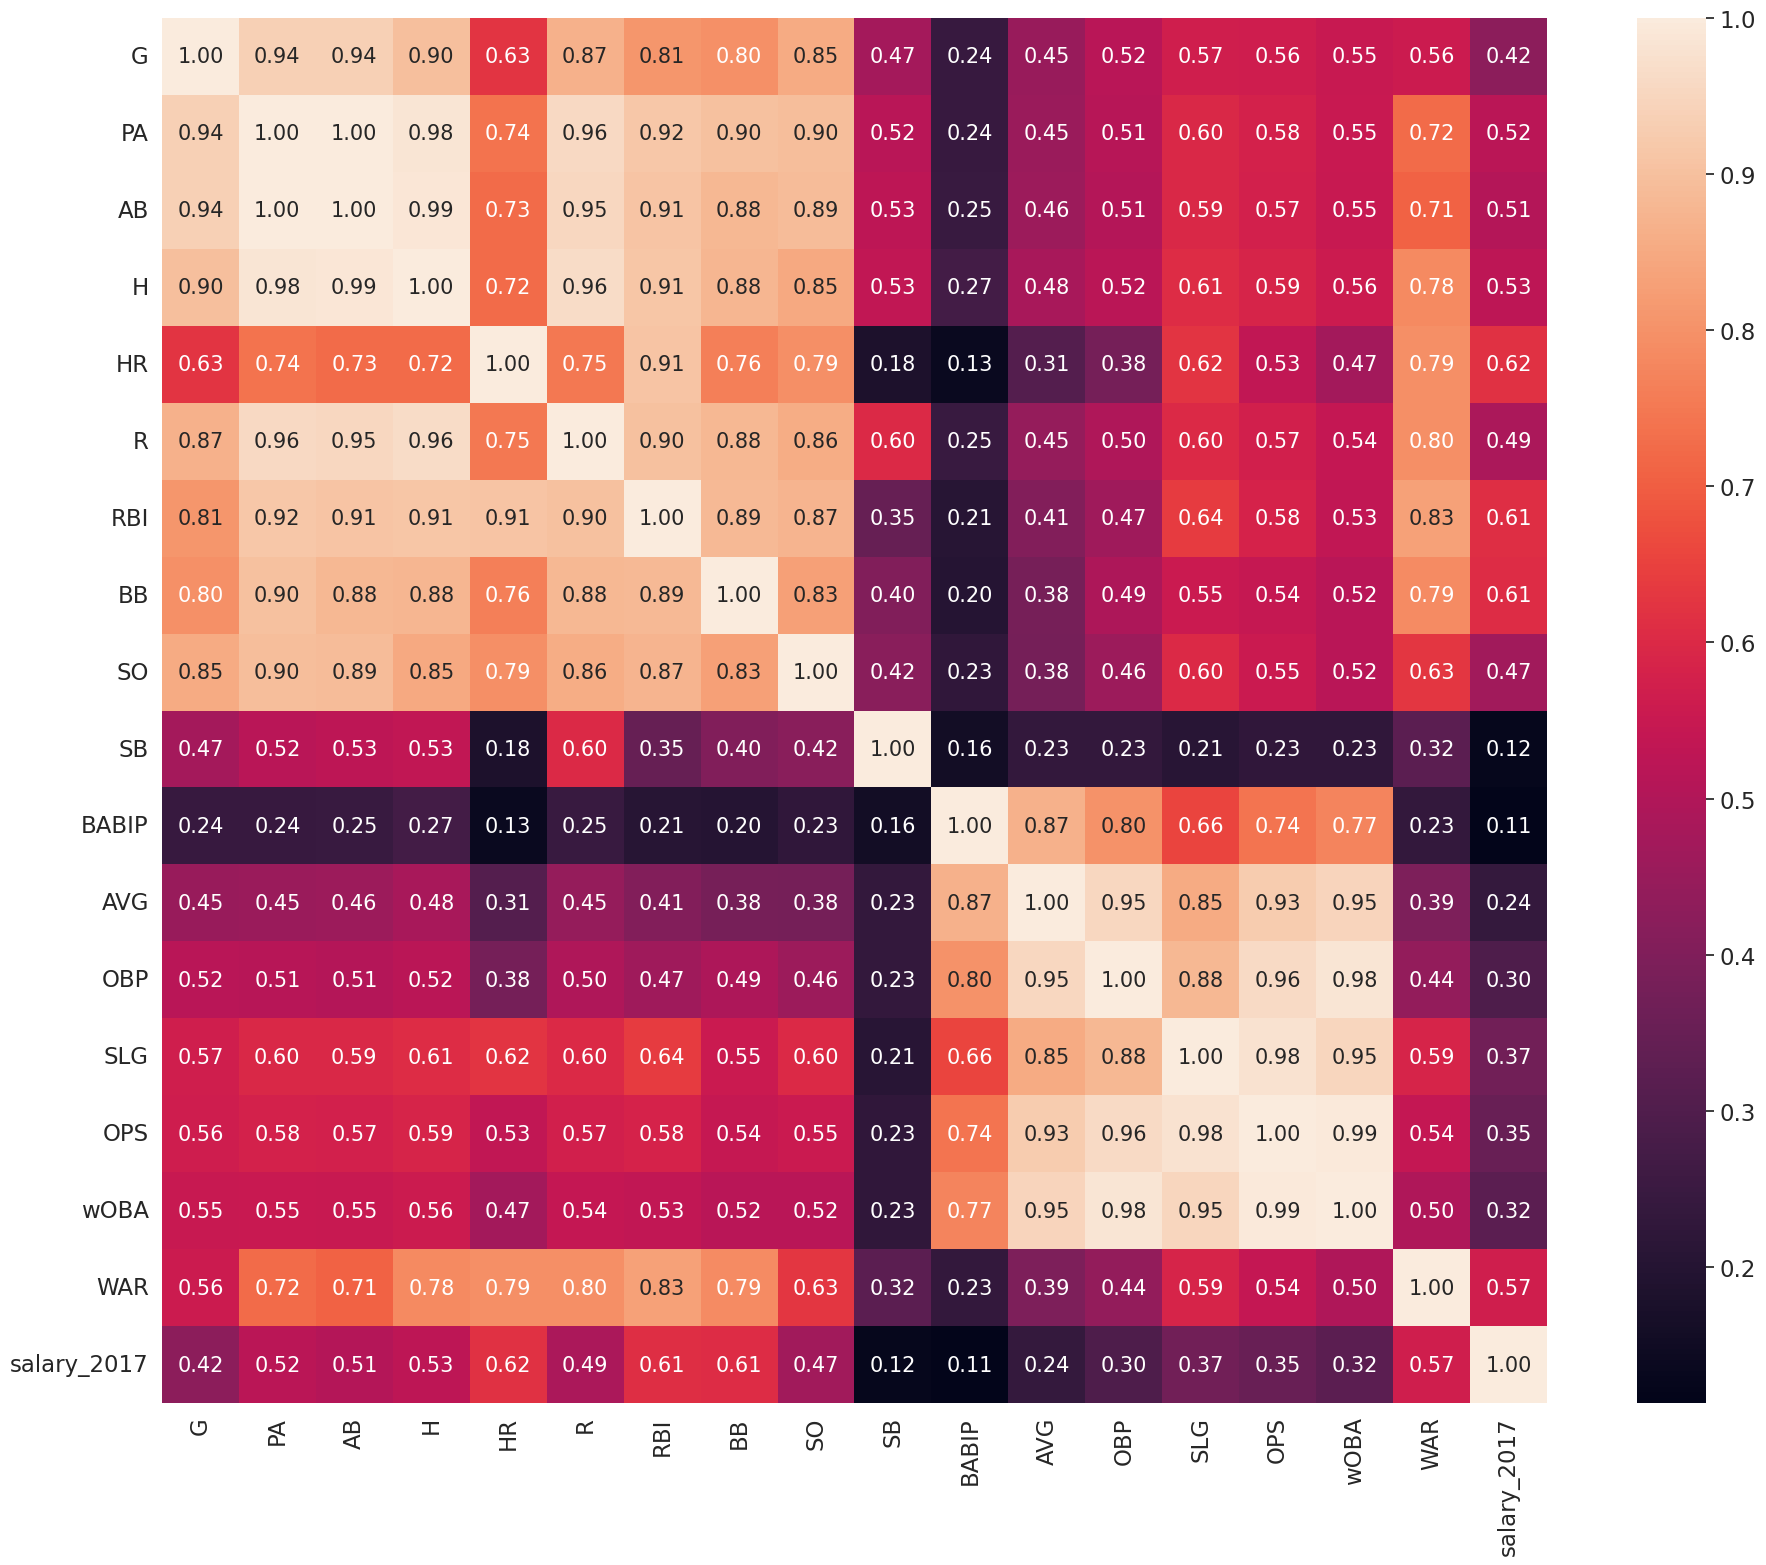

In [151]:
import seaborn as sns

# Batter(타자)간의 상관계수 행렬을 계산합니다.
corr = batter_df[scale_columns].corr(method='pearson')
show_cols = ['G', 'PA', 'AB', 'H', 'HR', 'R', 'RBI', 'BB', 'SO', 'SB',
'BABIP', 'AVG', 'OBP', 'SLG', 'OPS', 'wOBA', 'WAR', 'salary_2017']

"""
G: 게임 수 (Games)
PA: 타석 수 (Plate Appearances)
AB: 타수 (At Bats)
H: 안타 (Hits)
HR: 홈런 수 (Home Runs)
R: 득점 수 (Runs)
RBI: 타점 수 (Runs Batted In)
BB: 볼넷 수 (Walks)
SO: 삼진 수 (Strikeouts)
SB: 도루 수 (Stolen Bases)
BABIP: 인플레이 타율 (Batting Average on Balls In Play)
AVG: 타율 (Batting Average)
OBP: 출루율 (On-Base Percentage)
SLG: 장타율 (Slugging Percentage)
OPS: 출루율+장타율 (On-Base Plus Slugging)
wOBA: 가중 출루율 (Weighted On-Base Average)
WAR: 승리 기여도 (Wins Above Replacement)
salary_2017: 2017년 연봉 (Salary in 2017)
"""

# corr 행렬 히트맵을 시각화합니다.
plt.rc('font', family='NanumGothicOTF')
sns.set(font_scale=1.5)
hm = sns.heatmap(corr.values,
            cbar=True,
            annot=True, 
            square=True,
            fmt='.2f',
            annot_kws={'size': 15},
            yticklabels=show_cols,
            xticklabels=show_cols)

plt.tight_layout()
plt.show()

-----

### [회귀분석 예측 성능을 높이기 위한 방법 : 다중공선성 확인]

In [152]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [153]:
# Batter(타자)마다의 VIF 계수를 출력합니다.
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif.round(1)

/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,VIF Factor,features
0,5.8,BABIP
1,1.1,KIA
2,1.1,KT
3,1.2,LG
4,1.1,NC
5,inf,OPS
6,1.2,SK
7,21.5,WAR
8,2115.3,wOBA
9,14.2,경기


-----

### [적절한 Batter(타자)로 다시 학습하기]

In [154]:
# Batter(타자)를 재선정합니다.
X = batter_df[['타율', 'BABIP', '홈런', '경기', '연봉(2017)']]
y = batter_df['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=19)

In [155]:
# 모델을 학습합니다.
lr = linear_model.LinearRegression()
model = lr.fit(X_train, y_train)

In [156]:
# 결과를 출력합니다.
print(model.score(X_train, y_train)) # train R2 score를 출력합니다.
print(model.score(X_test, y_test)) # test R2 score를 출력합니다.

0.9050596311519321
0.9652624547233866


In [157]:
# 회귀 분석 모델을 평가합니다.
y_predictions = lr.predict(X_train)
print(sqrt(mean_squared_error(y_train, y_predictions))) # train RMSE score를 출력합니다.
y_predictions = lr.predict(X_test)
print(sqrt(mean_squared_error(y_test, y_predictions))) # test RMSE score를 출력합니다.

8527.034622282476
8415.532257832878


In [158]:
# Batter(타자)마다의 VIF 계수를 출력합니다.
X = batter_df[['타율', 'BABIP', '홈런', '경기', '연봉(2017)']]
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif.round(1)

,VIF Factor,features
0,5.4,타율
1,4.5,BABIP
2,2.2,홈런
3,2.0,경기
4,1.6,연봉(2017)


-----

# <Step4. 시각화> : 분석 결과의 시각화

### [예상 연봉과 실제 연봉 비교]

In [159]:
# 2018년 연봉을 예측하여 데이터프레임의 column으로 생성합니다.
X = batter_df[['타율', 'BABIP', '홈런', '경기', '연봉(2017)']]
predict_2018_salary = lr.predict(X)
batter_df['예측연봉(2018)'] = pd.Series(predict_2018_salary)

In [160]:
# 원래의 데이터 프레임을 다시 로드합니다.
batter = pd.read_csv(batter_file_path)
batter = batter[['선수명', '연봉(2017)']]

# 원래의 데이터 프레임에 2018년 연봉 정보를 합칩니다.
result_df = batter_df.sort_values(by=['y'], ascending=False)
result_df.drop(['연봉(2017)'], axis=1, inplace=True, errors='ignore')
result_df = result_df.merge(batter, on=['선수명'], how='left')
result_df = result_df[['선수명', 'y', '예측연봉(2018)', '연봉(2017)']]
result_df.columns = ['선수명', '실제연봉(2018)', '예측연봉(2018)', '작년연봉(2017)']

# 재계약하여 연봉이 변화한 선수만을 대상으로 관찰합니다.
result_df = result_df[result_df['작년연봉(2017)'] != result_df['실제연봉(2018)']]
result_df = result_df.reset_index()
result_df = result_df.iloc[:10, :]
result_df.head(10)

,index,선수명,실제연봉(2018),예측연봉(2018),작년연봉(2017)
0,3,손아섭,150000,70515.043923,65000
1,4,러프,140000,116185.496701,110000
2,9,번즈,73000,63131.465597,60000
3,10,스크럭스,70000,89465.880086,80000
4,17,양의지,60000,51411.509228,48000
5,20,손시헌,50000,40970.878133,40000
6,21,로맥,50000,41123.830592,30000
7,23,나성범,43000,43849.257534,35000
8,25,이용규,40000,7650.032706,90000
9,28,김주찬,40000,62099.094080,60000


In [161]:
import matplotlib as mpl
set(sorted([f.name for f in mpl.font_manager.fontManager.ttflist])) # 현재 OS 내에 설치된 폰트를 확인합니다.

{'DejaVu Sans',
 'DejaVu Sans Display',
 'DejaVu Sans Mono',
 'DejaVu Serif',
 'DejaVu Serif Display',
 'Humor Sans',
 'Liberation Mono',
 'Liberation Sans',
 'Liberation Sans Narrow',
 'Liberation Serif',
 'NanumBarunGothic',
 'NanumGothic',
 'NanumMyeongjo',
 'NanumSquare',
 'NanumSquareRound',
 'STIXGeneral',
 'STIXNonUnicode',
 'STIXSizeFiveSym',
 'STIXSizeFourSym',
 'STIXSizeOneSym',
 'STIXSizeThreeSym',
 'STIXSizeTwoSym',
 'cmb10',
 'cmex10',
 'cmmi10',
 'cmr10',
 'cmss10',
 'cmsy10',
 'cmtt10'}

<Axes: xlabel='선수명'>

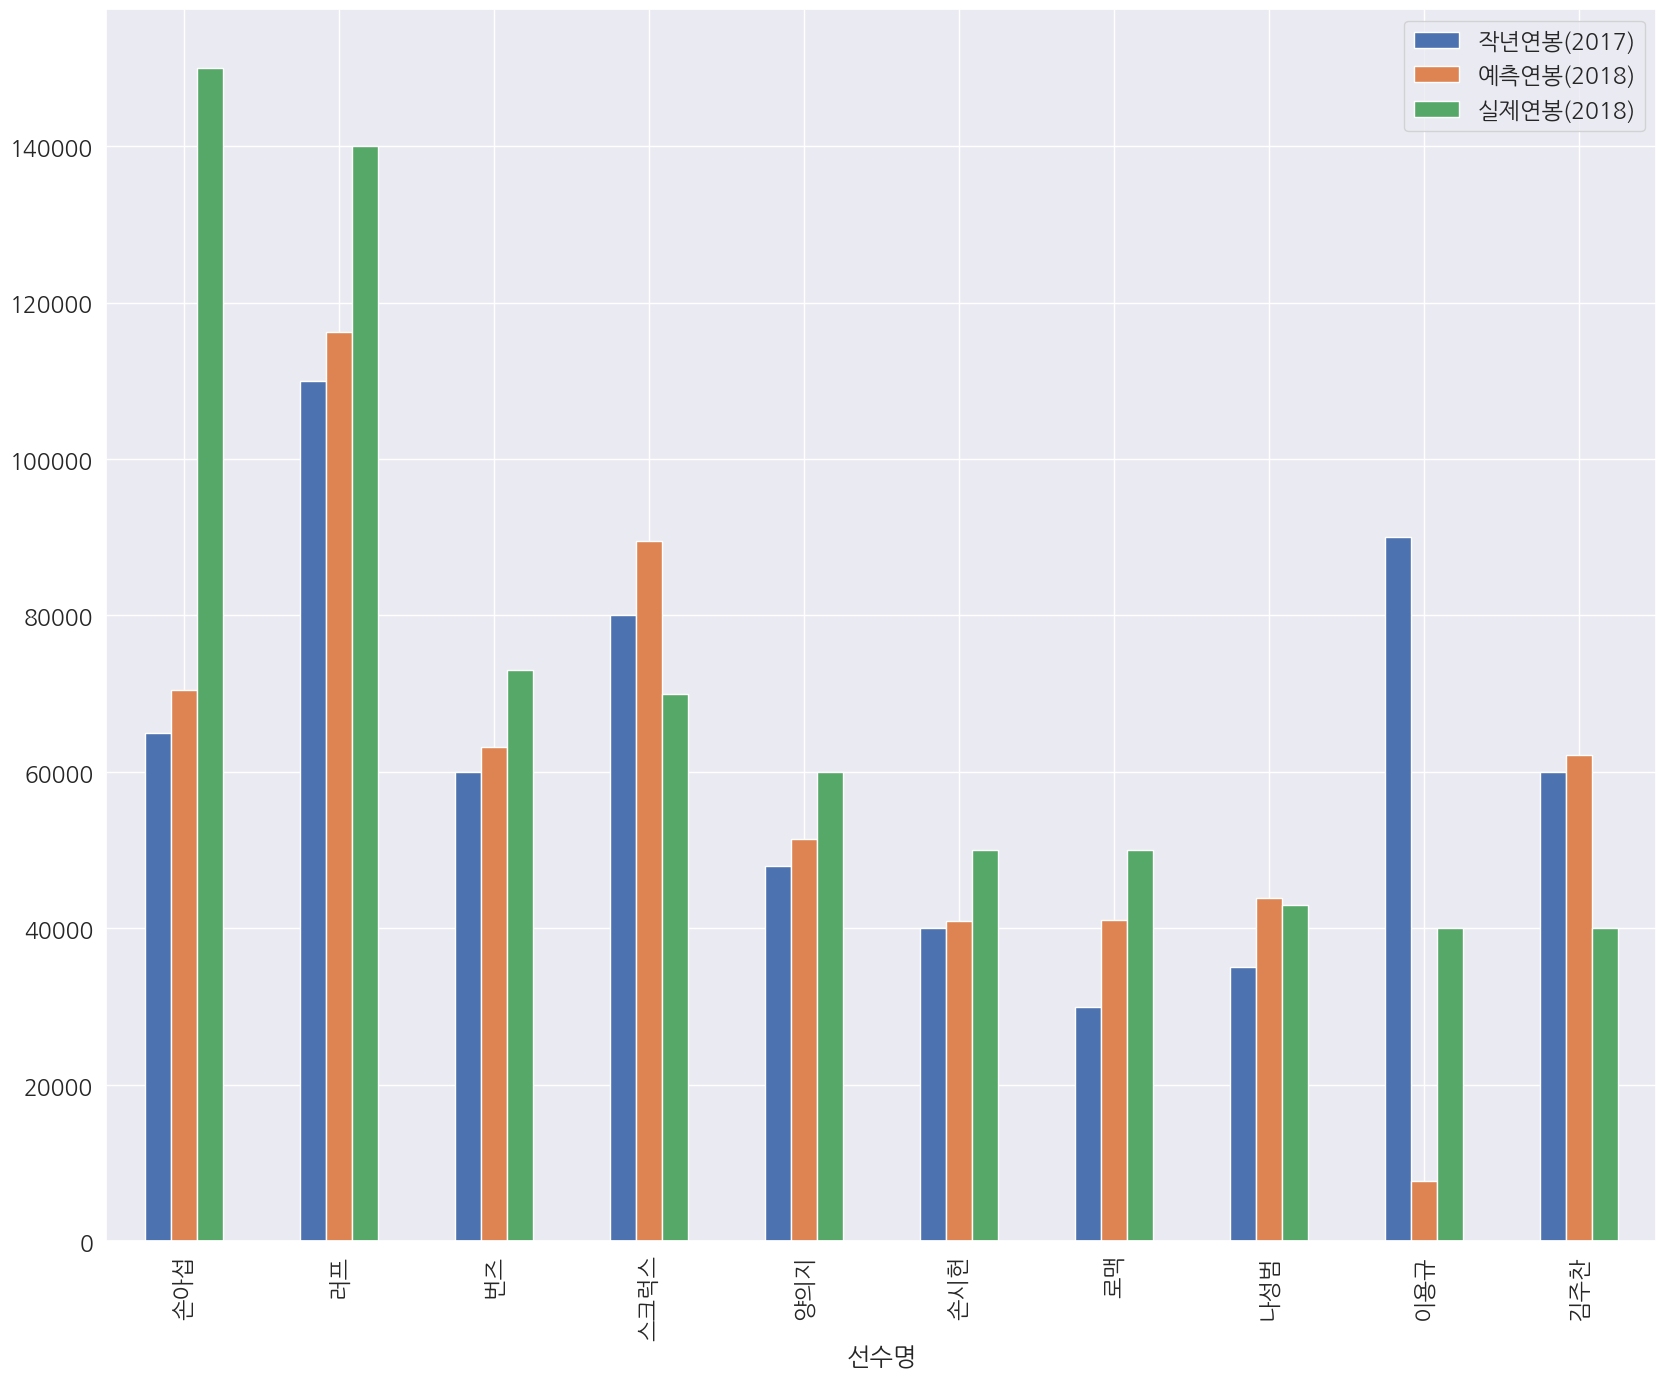

In [162]:
# 선수별 연봉 정보(작년 연봉, 예측 연봉, 실제 연봉)를 bar 그래프로 출력합니다.
mpl.rc('font', family='NanumGothic')
result_df.plot(x='선수명', y=['작년연봉(2017)', '예측연봉(2018)', '실제연봉(2018)'], kind="bar")